<a href="https://colab.research.google.com/github/alexandreib/ConformalPredictionTutorial/blob/main/JS_%7C_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
from google.colab import drive
drive.mount('/content/drive')
# import kagglehub
# kagglehub.login()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
# # !export KAGGLE_CONFIG_DIR=/content/drive/MyDrive/kaggle.json
# !mkdir -p ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions  download -c 'jane-street-real-time-market-data-forecasting' -p '/content/drive/MyDrive/kaggle/'

In [90]:
# !unzip /content/drive/MyDrive/kaggle/jane-street-real-time-market-data-forecasting.zip -d /content/drive/MyDrive/kaggle/

In [91]:
!pip install optuna==4.0.0, catboost==1.2.7

In [92]:
import gc,os, sys, warnings, ctypes, re, joblib, copy, json, collections, abc, tqdm, multiprocessing, random
libc = ctypes.CDLL('libc.so.6');
warnings.filterwarnings('ignore')

import optuna
from optuna.visualization import (plot_optimization_history,plot_param_importances,plot_parallel_coordinate)
from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import pandas as pd
pd.options.display.max_columns = None

import lightgbm, catboost, tensorflow, xgboost
print('Optuna Version',optuna.__version__)
print('LightGBM Version',lightgbm.__version__)
print('CatBoost Version',catboost.__version__)
print('XGBoost Version',xgboost.__version__)
print('TF Version',tensorflow.__version__)

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupKFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_regression

# import kaggle_evaluation.jane_street_inference_server

def is_interactive():
    # return 'runtime' in get_ipython().config.IPKernelApp.connection_file
    return True #True False
print('Interactive?', is_interactive())

def is_kaggle_gpu_enabled():
    from tensorflow.python.client import device_lib
    # when only CPU is enabled the list shows two CPU entries, otherwise there are more, listing GPU as well
    # return len(device_lib.list_local_devices()) > 2
    return False
print('is_kaggle_gpu_enabled?', is_kaggle_gpu_enabled())

class dotdict(collections.defaultdict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    def __str__(self):
        return str(' | '.join([f"{key}: {value}" for key, value in self.items()]))

Optuna Version 4.0.0
LightGBM Version 4.5.0
CatBoost Version 1.2.7
XGBoost Version 2.1.1
TF Version 2.17.0
Interactive? True
is_kaggle_gpu_enabled? False


In [93]:
CFG = dotdict(dict)
#
CFG.l_models = ['catboost', 'xgboost'] #catboost, lgbm, xgboost, nn
CFG.fold_name = 'time_serie_split' #time_serie_split , add blocked_time_serie_split
CFG.fold_n = 5 if not is_interactive() else 2
CFG.fold_train_test_split = 0.8
CFG.l_optuna = []
#
CFG.drop =['responder_0','responder_1','responder_2','responder_3','responder_4','responder_5',  'responder_7', 'responder_8',
          'date_id','time_id', 'partition_id',
           #'weight', 'responder_6',
          ]
CFG.categoricals = ['symbol_id']
#
CFG.cols_onehot = []
# Flow Parameters
CFG.load = False
CFG.load_path = ''
CFG.l_permutation_importance = []
CFG.post_processing = False
CFG.device = 'gpu' if is_kaggle_gpu_enabled() else 'cpu'
# CFG.train_path = '/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet'
CFG.train_path = '/content/drive/MyDrive/kaggle/'
CFG.save_path = '/content/drive/MyDrive/kaggle/save/'
CFG.n_rows = 47_127_338 if not is_interactive() else 100_000
CFG.col_target = 'responder_6'
CFG.col_weight = 'weight'# None or column name : 'weight'
CFG.weights = [1/len(CFG.l_models) for x in CFG.l_models]

# Models Parameters
CFG.lgbm = dotdict(dict)
CFG.lgbm.objective = 'rmse'
CFG.lgbm.verbose = -1
CFG.lgbm.random_seed = 42
CFG.lgbm.num_trees = 3000 if not is_interactive() else 5 #num_iteration, n_iter, num_tree, num_trees, num_round, num_rounds, nrounds, num_boost_round, n_estimators, max_iter
CFG.lgbm.learning_rate = 0.03
CFG.lgbm.max_depth = 12
CFG.lgbm.min_data_in_leaf = 25
CFG.lgbm.num_leaves = 64
CFG.lgbm.subsample = 1
CFG.lgbm.reg_lambda = 0.0005

CFG.lgbm.device = CFG.device.lower()
CFG.lgbm.gpu_use_dp = True if CFG.device.lower() == 'gpu' else False
CFG.lgbm.metric  = 'rmse'
CFG.lgbm.extra_trees = True
CFG.lgbm.colsample_bytree = 0.8
CFG.lgbm.subsample_freq = 1
CFG.lgbm.early_stopping_rounds = 100
#
CFG.catboost = dotdict(dict)
CFG.catboost.objective = 'RMSE'
CFG.catboost.verbose = -1
CFG.catboost.random_seed = 42
CFG.catboost.num_trees = 3000 if not is_interactive() else 5 # num_boost_round, n_estimators, num_trees
CFG.catboost.learning_rate = 0.03
CFG.catboost.max_depth = 12
CFG.catboost.min_data_in_leaf = 25
CFG.catboost.num_leaves = 64
# CFG.catboost.subsample = 1 # or add bootstrap_type='Poisson'
CFG.catboost.reg_lambda = 0.0005

CFG.catboost.task_type = CFG.device.upper()
CFG.catboost.eval_metric = 'RMSE'
if CFG.device.lower() == 'cpu' : CFG.catboost.colsample_bylevel = 0.8
CFG.catboost.random_strength = 0.01
CFG.catboost.grow_policy = 'Lossguide'#  default SymmetricTree' ## Needed for Num_leaves parameter
CFG.catboost.early_stopping_rounds = 100
#
CFG.xgboost = dotdict(dict)
CFG.xgboost.objective = 'reg:squarederror'
CFG.xgboost.verbosity = 1
CFG.xgboost.seed = 42
CFG.xgboost.n_estimators = 3000 if not is_interactive() else 5 # num_boost_round, n_estimators, num_trees
CFG.xgboost.learning_rate = 0.03
CFG.xgboost.max_depth = 12
CFG.xgboost.subsample = 1
CFG.xgboost.colsample_bylevel = 0.8
CFG.xgboost.reg_lambda = 0.0005
CFG.xgboost.device = CFG.device.lower()
CFG.xgboost.early_stopping_rounds = 100
CFG.xgboost.enable_categorical = True if len(CFG.categoricals) > 0 else False
#
CFG.nn = dotdict(dict)
CFG.nn.epochs = 150 if not is_interactive() else 1
CFG.nn.lr = 0.01
CFG.nn.lr_start = 1e-5
CFG.nn.lr_max = 1e-2
CFG.nn.lr_rampup = 2
CFG.nn.lr_sustain = 1
CFG.nn.lr_decay = 0.75
#
# CFG = json.load(open(CFG.load_path + '/CFG.json', 'r'))
json.dump(CFG, open(CFG.save_path + 'CFG.json', 'w'))

if not is_interactive():
    for key, value in CFG.items() :
        print(f'{key} : {value}')

In [94]:
train = pl.read_parquet(CFG.train_path + 'train.parquet', n_rows = CFG.n_rows)
print(train.head(1))
print(train.shape)

lags = pl.read_parquet(CFG.train_path + 'lags.parquet')
print(lags.head(1))
print(lags.shape)

lag_all  = train['date_id','time_id','symbol_id','responder_0','responder_1','responder_2','responder_3','responder_4','responder_5','responder_6','responder_7','responder_8',]
lag_all = lag_all.with_columns(pl.col('date_id') + 1)
lag_all = lag_all.rename({'responder_0' : 'responder_0_lag_1',
                 'responder_1' : 'responder_1_lag_1',
                 'responder_2' : 'responder_2_lag_1',
                 'responder_3' : 'responder_3_lag_1',
                 'responder_4' : 'responder_4_lag_1',
                 'responder_5' : 'responder_5_lag_1',
                 'responder_6' : 'responder_6_lag_1',
                 'responder_7' : 'responder_7_lag_1',
                 'responder_8' : 'responder_8_lag_1'})
print(lag_all.head(1))
print(lag_all.shape)
gc.collect()

shape: (1, 93)
┌─────────┬─────────┬───────────┬──────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ weight   ┆ … ┆ responder_ ┆ responder_ ┆ responder_ ┆ partition_ │
│ ---     ┆ ---     ┆ ---       ┆ ---      ┆   ┆ 6          ┆ 7          ┆ 8          ┆ id         │
│ i16     ┆ i16     ┆ i8        ┆ f32      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│         ┆         ┆           ┆          ┆   ┆ f32        ┆ f32        ┆ f32        ┆ i64        │
╞═════════╪═════════╪═══════════╪══════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 0       ┆ 0       ┆ 1         ┆ 3.889038 ┆ … ┆ 0.775981   ┆ 0.346999   ┆ 0.095504   ┆ 0          │
└─────────┴─────────┴───────────┴──────────┴───┴────────────┴────────────┴────────────┴────────────┘
(100000, 93)
shape: (1, 12)
┌─────────┬─────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ responder_ ┆ …

4582

In [95]:
# def reduce_memory_usage_pl(df):
#     print(f"Memory usage of dataframe is {round(df.estimated_size('mb'), 2)} MB")
#     Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
#     Numeric_Float_types = [pl.Float32,pl.Float64]
#     for col in df.columns:
#         col_type = df[col].dtype
#         c_min = df[col].min()
#         c_max = df[col].max()
#         if col_type in Numeric_Int_types:
#             if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                 df = df.with_columns(df[col].cast(pl.Int8))
#             elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                 df = df.with_columns(df[col].cast(pl.Int16))
#             elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                 df = df.with_columns(df[col].cast(pl.Int32))
#             elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                 df = df.with_columns(df[col].cast(pl.Int64))
#         elif col_type in Numeric_Float_types:
#             if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                 df = df.with_columns(df[col].cast(pl.Float32))
#             else :
#                 pass
#         elif col_type == pl.Utf8:
#             df = df.with_columns(df[col].cast(pl.Categorical))
#         else:
#             pass
#     print(f"Memory usage of dataframe became {round(df.estimated_size('mb'), 2)} MB")
#     return df

# train = reduce_memory_usage_pl(train)

# Fit, Features, Encode ...

In [96]:
class FE:
    def __init__(self):
        self.dic_tfid_vectorizer = {}
        self.dic_tfid_selected_feature = {}

    def get_new_columns(self, df, lags ) :
        global lag_all
        if lags is not None:
            lag_all = pl.concat([lags , lag_all])
            lags_all = lag_all.unique(['date_id','time_id','symbol_id'])
            df.join(lags_all, on = ['date_id', 'time_id', 'symbol_id'], how = 'left')
        return df

    def encoders_fit(self, df) :
        ### ONE HOT ENCODER FIT
        for col in CFG.cols_onehot :
            if col not in cols: cols[col] = dotdict(dict)
            cols[col].one_hot_encoder = list(df[col].unique(maintain_order = True))

    def encoders_transform(self, df):
        ### ONE HOT ENCODER TRANSFORM
        for i, col in enumerate(CFG.cols_onehot) :
            for unique in cols[col].one_hot_encoder:
                df = df.with_columns((df[col] == unique).cast(pl.Int8).alias(f'ofe_{col}_{i}'))
        return df

    def feature_engineering(self, df) :
        return df

    def scaler_fit(self, df):
        cols.numercials_means = df[cols.numericals].mean().to_dicts()[0]
        cols.numercials_std = df[cols.numericals].std().to_dicts()[0]

    def scaler_transform(self, df):
        for col in cols.numericals:
            df = df.with_columns( (pl.col(col) - cols.numercials_means[col]) / cols.numercials_std[col])
        return df

    def clean(self, df):
        ## DROP
        df = df.drop([col for col in cols.drop if col in df.columns])

        ## FILL / CAST
        if len( CFG.categoricals ) > 0 : df[cols.categoricals] = df[cols.categoricals].fill_null('nan')
        df = df.with_columns([pl.col(col).cast(pl.String).cast(pl.Categorical) for col in CFG.categoricals if col in df.columns]) #
        for col in cols.numericals:
            if col in df.columns:
                df = df.with_columns(pl.col(col).cast(pl.Float64))

        ##PANDA
        df = df.to_pandas()
        return df

In [97]:
cols = dotdict(dict)

## Data Pipeline
print(f'Shape train: {train.shape}')
fe = FE()
train = fe.get_new_columns(train, lags)

fe.encoders_fit(train)
print(f'Shape train: {train.shape}')

Shape train: (100000, 93)
Shape train: (100000, 93)


### Folds Creation

Shape train: (100000, 93)


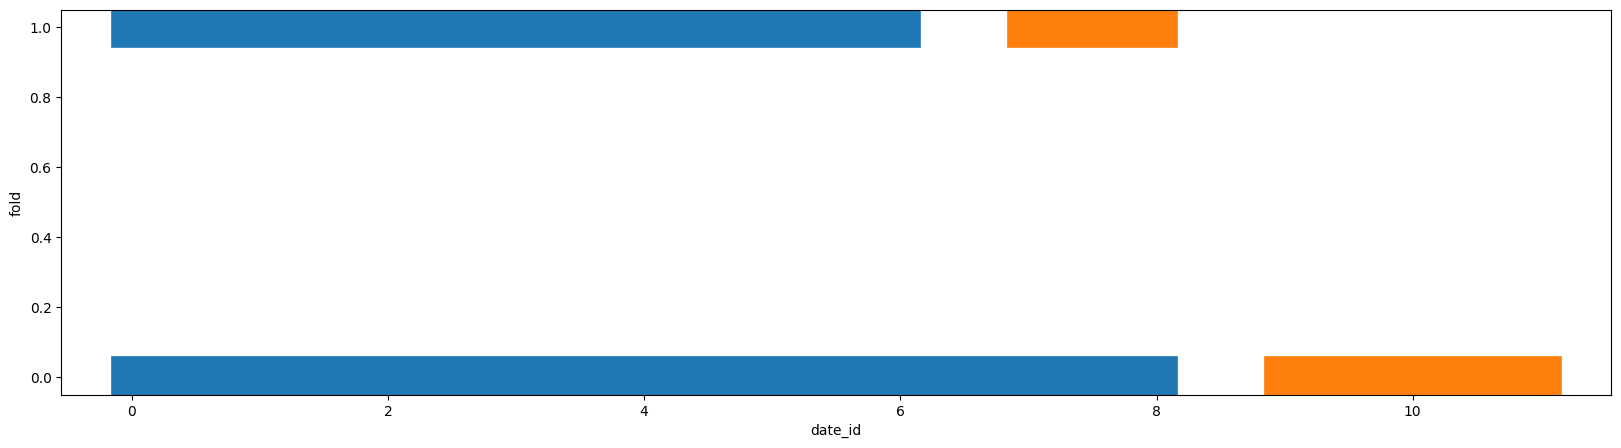

Shape train: (100000, 93)


In [98]:
class fold():
    ## Kfold done before concat with df_duplicated
    def prepare(self, df) :
        date_id = df['date_id'].to_pandas()
        uniques = list(date_id.unique())
        df_folds = pd.DataFrame(date_id)

        plt.figure(figsize=(20,5))
        plt.legend('',frameon=False)
        self.folds = {}
        if CFG.fold_name == 'time_serie_split' :
            for fold in range(CFG.fold_n) :
                split = int(len(uniques) * CFG.fold_train_test_split)
                train_dates = uniques[:split]
                valid_dates = uniques[split:]
                train_index = list(date_id[date_id.isin(train_dates)].index)
                valid_index = list(date_id[date_id.isin(valid_dates)].index)
                self.folds[fold] = (train_index, valid_index)
                df_folds.loc[train_index, fold] = 'train'
                df_folds.loc[valid_index, fold] = 'valid'
                uniques = train_dates
                df_folds['fold'] = fold
                ax = sns.lineplot(df_folds[['date_id','fold', fold]].dropna(subset=fold), x='date_id', y = 'fold', hue = fold, linewidth = 30)
                ax.get_legend().remove()
            plt.show()

        if CFG.fold_name == 'blocked_time_serie_split' :
            split = int(len(uniques) / CFG.fold_n) + 1
            for fold in range(CFG.fold_n) :
                fold_l_date_id = uniques[split * fold : split * (fold + 1)]
                fold_index= list(date_id[date_id.isin(fold_l_date_id)].index)

                train_index = fold_index[:int(len(fold_index) * CFG.fold_train_test_split)]
                valid_index = fold_index[int(len(fold_index) * CFG.fold_train_test_split):]
                self.folds[fold] = (train_index, valid_index)
                df_folds.loc[train_index, fold] = 'train'
                df_folds.loc[valid_index, fold] = 'valid'
                df_folds['fold'] = fold
                ax = sns.lineplot(df_folds[['date_id','fold', fold]].dropna(subset=fold), x='date_id', y = 'fold', hue = fold, linewidth = 30)
                ax.get_legend().remove()
            plt.show()
        return df

    def get_index(self, fold) :
        return self.folds[fold]

fld = fold()
print(f'Shape train: {train.shape}')
train = fld.prepare(train)
print(f'Shape train: {train.shape}')

### Transform and Feature Engineering

In [99]:
print(f'Shape train: {train.shape}')
train = fe.encoders_transform(train)
train = fe.feature_engineering(train)
print(f'Shape train: {train.shape}')
train[CFG.categoricals].head(1)
train.head(1)

Shape train: (100000, 93)
Shape train: (100000, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,null,-0.169586,null,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,null,…,null,null,-0.808103,null,-2.037683,0.727661,null,-0.989118,-0.345213,-1.36224,null,null,null,null,null,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,null,null,-0.261412,-0.211486,-0.335556,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504,0


### Columns Selection

In [100]:
cols.drop = copy.deepcopy(CFG.drop)
# cols_onehot
cols.drop += CFG.cols_onehot
# cols_percentages_to_drop
# cols_percentages_to_drop = [col for col in train.columns if train[col].value_counts(normalize = True).max()['proportion'].item() > 0.99]
# print('cols_percentages_to_drop : ', cols_percentages_to_drop)
# cols.drop += cols_percentages_to_drop
cols.drop = list(dict.fromkeys(cols.drop)) #removing duplicates

cols.categoricals = list(dict.fromkeys(copy.deepcopy(CFG.categoricals)))
### Priotity to CAT cols => if col in cat it will not be dropped
cols.drop = [col for col in cols.drop if col not in cols.categoricals]
### Drop categoricals col which are one hot encoded
cols.categoricals = [col for col in cols.categoricals if col not in CFG.cols_onehot]

cols.numericals = [col for col in train.columns if (col not in cols.categoricals + cols.drop + [CFG.col_target, CFG.col_weight] and train[col].dtype.is_numeric())]
cols.numericals = list(dict.fromkeys(cols.numericals))
# double_check_cols = [col for col in train.columns if col not in cols.categoricals + cols.drop + cols.numericals + [CFG.col_target]]
# cols.drop +=  double_check_cols
# print(f"double_check_cols : {double_check_cols}")

cols.drop = list(dict.fromkeys(cols.drop)) #removing duplicates
print(f"len(drop) : {len(cols.drop)}")
print(cols.drop)

len(drop) : 11
['responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5', 'responder_7', 'responder_8', 'date_id', 'time_id', 'partition_id']


In [101]:
cols.lgbm = dotdict(dict)
cols.catboost = dotdict(dict)
cols.xgboost = dotdict(dict)
cols.nn = dotdict(dict)

cols.lgbm.drop = copy.deepcopy(cols.drop)
cols.catboost.drop = copy.deepcopy(cols.drop)
cols.xgboost.drop = copy.deepcopy(cols.drop)
cols.nn.drop = copy.deepcopy(cols.drop)

############### ADD SPECIFIC drops per models
cols.lgbm.drop = list(dict.fromkeys(cols.lgbm.drop))
cols.catboost.drop = list(dict.fromkeys(cols.catboost.drop))
cols.xgboost.drop = list(dict.fromkeys(cols.xgboost.drop))
cols.nn.drop = list(dict.fromkeys(cols.nn.drop))
###############

cols.lgbm.features = list(dict.fromkeys([col for col in cols.numericals + cols.categoricals if col not in cols.lgbm.drop]))
cols.catboost.features  = list(dict.fromkeys([col for col in cols.numericals + cols.categoricals if col not in cols.catboost.drop]))
cols.xgboost.features = list(dict.fromkeys([col for col in cols.numericals + cols.categoricals if col not in cols.xgboost.drop]))
cols.nn.features = list(dict.fromkeys([col for col in cols.numericals + cols.categoricals if col not in cols.nn.drop]))

cols.lgbm.categoricals = list(dict.fromkeys([col for col in cols.categoricals if col not in cols.lgbm.drop]))
cols.catboost.categoricals = list(dict.fromkeys([col for col in cols.categoricals if col not in cols.catboost.drop]))
cols.xgboost.categoricals = list(dict.fromkeys([col for col in cols.categoricals if col not in cols.xgboost.drop]))
cols.nn.categoricals = list(dict.fromkeys([col for col in cols.categoricals if col not in cols.nn.drop]))

cols.lgbm.numericals = list(dict.fromkeys([col for col in cols.numericals if col not in cols.lgbm.drop]))
cols.catboost.numericals = list(dict.fromkeys([col for col in cols.numericals if col not in cols.catboost.drop]))
cols.xgboost.numericals = list(dict.fromkeys([col for col in cols.numericals if col not in cols.xgboost.drop]))
cols.nn.numericals  = list(dict.fromkeys([col for col in cols.numericals if col not in cols.nn.drop]))

json.dump(cols, open(CFG.save_path + 'cols.json', 'w'))
print('*' * 70)
print(f"number categoricals cols : {len(cols.categoricals)}, number numericals cols : {len(cols.numericals)}, number drop cols : {len(cols.drop)}, number target : 1")
print(f"total = {len(cols.categoricals + cols.numericals + cols.drop + [CFG.col_target] + [CFG.col_weight])} == {train.shape[1]} : train.shape")
print(f"cat categoricals : {cols.categoricals}")
print(f"debug : {[col for col in cols.categoricals + cols.numericals + cols.drop if col not in train.columns]}")

print('*' * 70)
print(f"len(cols.lgbm.drop) :{len(cols.lgbm.drop)}")
print(f"len(cols.catboost.drop) :{len(cols.catboost.drop)}")
print(f"len(cols.xgboost.drop) :{len(cols.xgboost.drop)}")
print(f"len(cols.nn.drop) :{len(cols.nn.drop)}")

print('*' * 70)
print(f"lgbm.numericals: {len(cols.lgbm.numericals)}, lgbm.categoricals : {len(cols.lgbm.categoricals)}")
print(f"catboost.numericals : {len(cols.catboost.numericals)}, catboost.categoricals : {len(cols.catboost.categoricals)}")
print(f"xgboost.numericals : {len(cols.xgboost.numericals)}, xgboost.categoricals : {len(cols.xgboost.categoricals)}")
print(f"nn.numericals: {len(cols.nn.numericals)}, nn.categoricals : {len(cols.nn.categoricals)}")

print('*' * 70)
for name in CFG.l_models :
    #if condition returns True, then nothing happens:
    assert CFG.col_target not in cols[name].numericals, f'CFG.col_target is in cols.{name}.numericals'
    assert CFG.col_target not in cols[name].categoricals, f'CFG.col_target is in cols.{name}.numericals'
    assert CFG.col_weight not in cols[name].numericals, f'CFG.col_weight is in cols.{name}.numericals'
    assert CFG.col_weight not in cols[name].categoricals, f'CFG.col_weight is in cols.{name}.numericals'

**********************************************************************
number categoricals cols : 1, number numericals cols : 79, number drop cols : 11, number target : 1
total = 93 == 93 : train.shape
cat categoricals : ['symbol_id']
debug : []
**********************************************************************
len(cols.lgbm.drop) :11
len(cols.catboost.drop) :11
len(cols.xgboost.drop) :11
len(cols.nn.drop) :11
**********************************************************************
lgbm.numericals: 79, lgbm.categoricals : 1
catboost.numericals : 79, catboost.categoricals : 1
xgboost.numericals : 79, xgboost.categoricals : 1
nn.numericals: 79, nn.categoricals : 1
**********************************************************************


### Scale

In [102]:
fe.scaler_fit(train)
train = fe.scaler_transform(train)

print(f'Shape: {train.shape}')
train.head(1)

Shape: (100000, 93)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64
0,0,1,3.889038,null,null,null,null,null,0.920475,0.262276,0.353894,-0.755199,-0.580844,0.862013,-0.344936,-1.183032,-0.236064,-0.934914,null,-0.440601,null,-1.510001,-1.792185,0.992471,null,1.028401,1.199989,-0.901658,-0.584469,null,null,1.357114,-0.47132,-0.362535,null,null,…,null,null,-0.493149,null,-2.039107,0.875836,null,-0.980022,-0.25172,-1.443361,null,null,null,null,null,-1.316559,-0.251443,-0.699553,-1.224017,-0.114836,-0.790307,null,null,-0.18871,-0.105384,-0.342607,-0.233251,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504,0


### Clean

In [103]:
train = fe.clean(train)

print(f'Shape: {train.shape}')
print('Memory usage: {:.2f} MB\n'.format(train.memory_usage(index=True).sum() / 1024**2))
display(train.head(1))
display(train[CFG.categoricals].head(1))

Shape: (100000, 82)
Memory usage: 61.13 MB



,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6
0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.920475,0.262276,0.353894,-0.755199,-0.580844,0.862013,-0.344936,-1.183032,-0.236064,-0.934914,NaN,-0.440601,NaN,-1.510001,-1.792185,0.992471,NaN,1.028401,1.199989,-0.901658,-0.584469,NaN,NaN,1.357114,-0.47132,-0.362535,NaN,NaN,NaN,0.76256,0.721351,0.264848,-0.190811,-0.263206,NaN,-0.492657,NaN,NaN,-0.044098,NaN,NaN,NaN,0.332061,1.133204,0.525556,NaN,0.068201,NaN,NaN,-0.493149,NaN,-2.039107,0.875836,NaN,-0.980022,-0.25172,-1.443361,NaN,NaN,NaN,NaN,NaN,-1.316559,-0.251443,-0.699553,-1.224017,-0.114836,-0.790307,NaN,NaN,-0.18871,-0.105384,-0.342607,-0.233251,0.775981


,symbol_id
0,1


In [104]:
new_cols_drop = [col for col in train.columns if train[col].isnull().sum() == train.shape[0]]
print(new_cols_drop)
new_cols_drop = [col for col in train.columns if train[col].isna().sum() == train.shape[0]]
print(new_cols_drop)
new_cols_drop = [col for col in train.columns if train[col].nunique() == 1]
print(new_cols_drop)

# duplicateColumnNames = set()
# for x in range(train.shape[1]):
#     for y in range(x + 1, train.shape[1]):
#         if train.iloc[:, x].equals(train.iloc[:, y]):
#             duplicateColumnNames.add(train.columns[y])
# print(list(duplicateColumnNames))

['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_21', 'feature_26', 'feature_27', 'feature_31']
['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_21', 'feature_26', 'feature_27', 'feature_31']
[]


# Train

Learning rate schedule: 1e-05 to 1e-05 to 1e-05


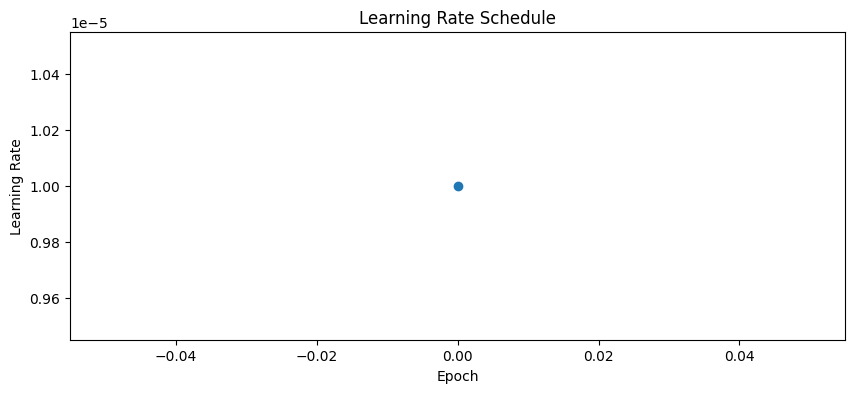

In [105]:
def lrfn(epoch):
    if epoch < CFG.nn.lr_rampup:
        lr = (CFG.nn.lr_max - CFG.nn.lr_start) / CFG.nn.lr_rampup * epoch + CFG.nn.lr_start
    elif epoch < CFG.nn.lr_rampup + CFG.nn.lr_sustain:
        lr = CFG.nn.lr_max
    else:
        lr = CFG.nn.lr_max * CFG.nn.lr_decay **((epoch - CFG.nn.lr_rampup -  CFG.nn.lr_sustain)//2)
    return lr

rng = [i for i in range(CFG.nn.epochs)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(lr_y[0], max(lr_y), lr_y[-1]))
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()

lr_callback = tensorflow.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
es_callback = tensorflow.keras.callbacks.EarlyStopping (monitor = 'val_root_mean_squared_error', patience = 10, verbose = 1, restore_best_weights=True)

In [106]:
# Custom R2 metric for XGBoost
def r2_xgboost(y_true, y_pred, sample_weight= None):
    r2 = 1 - np.average((y_pred - y_true) ** 2, weights=sample_weight) / (np.average((y_true) ** 2, weights=sample_weight) + 1e-38)
    return -r2

# Custom R2 metric for LightGBM
def r2_lgb(y_true, y_pred, sample_weight):
    r2 = 1 - np.average((y_pred - y_true) ** 2, weights=sample_weight) / (np.average((y_true) ** 2, weights=sample_weight) + 1e-38)
    return 'r2', r2, True

# Custom R2 metric for CatBoost
class r2_cbt(object):
    def get_final_error(self, error, weight):
        return 1 - error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        approx = approxes[0]
        error_sum = 0.0
        weight_sum = 0.0
        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w * (target[i] ** 2)
            error_sum += w * ((approx[i] - target[i]) ** 2)
        return error_sum, weight_sum

CFG.lgbm.eval_metric = [r2_lgb]
CFG.catboost.eval_metric = r2_cbt()
CFG.xgboost.eval_metric = r2_xgboost
CFG.xgboost.disable_default_eval_metric = True
# CFG.nn.eval_metric =

In [107]:
class model(abc.ABC) :
    def __init__(self, name, params):
        self.name = name
        if params is None : self.params = CFG[self.name]
        else: self.params = params
        print(f'Create model : {self.name}')
        print(f'Params: {self.params}')

    def load(self, fold) :
        self.model = joblib.load(CFG.load_path + f'/{fold}_{self.name}_model')

    def save(self, fold) :
        joblib.dump(self.model, CFG.save_path + f'{fold}_{self.name}_model')

    @abc.abstractmethod
    def fit(self, fold, X_train, X_valid, y_train, y_valid, w_train = None, w_valid = None) :
        pass

    def predict(self, df) :
        return self.model.predict(df[cols[self.name].features])

    def get_feature_importance(self) :
        return dict(zip(cols[self.name].features, self.model.feature_importances_))

class model_nn(model) :
    def __init__(self, name, params):
        super().__init__(name, params)
        x_input_cats = tensorflow.keras.layers.Input(shape=(len(cols[self.name].categoricals),))
        embs = []
        for j, col in enumerate(cols.nn.categoricals):
            e = tensorflow.keras.layers.Embedding(cols[col].cat_size, cols[col].cat_emb)
            x = e(x_input_cats[:,j])
            x = tensorflow.keras.layers.Flatten()(x)
            embs.append(x)

        # NUMERICAL FEATURES
        x_input_nums = tensorflow.keras.layers.Input(shape=(len(cols[self.name].numericals),))

        # COMBINE
        x = tensorflow.keras.layers.Concatenate(axis=-1)(embs+[x_input_nums])
        x = tensorflow.keras.layers.Dense(256, activation='relu')(x)
        x = tensorflow.keras.layers.Dense(256, activation='relu')(x)
        x = tensorflow.keras.layers.Dense(256, activation='relu')(x)
        x = tensorflow.keras.layers.Dense(1, activation='linear')(x)

        self.model = tensorflow.keras.models.Model(inputs=[x_input_cats, x_input_nums], outputs=x)
        self.model.compile(optimizer=tensorflow.keras.optimizers.Adam(0.001),
                           loss="mean_squared_error",
                           metrics=[tensorflow.keras.metrics.RootMeanSquaredError()])

    def fit(self, fold, X_train, X_valid, y_train, y_valid, w_train = None, w_valid = None) :
        self.model.fit([X_train[cols[self.name].categoricals].astype(int).values, X_train[cols[self.name].numericals].values],
                       y_train,
                       validation_data = ([X_valid[cols[self.name].categoricals].astype(int).values, X_valid[cols[self.name].numericals].values], y_valid),
                       callbacks = [lr_callback, es_callback],
                       batch_size=64, epochs=self.params.epochs, verbose=2)

    def predict(self, df) :
        return self.model.predict([df[cols[self.name].categoricals].astype(int).values, df[cols[self.name].numericals].values], verbose = 0).flatten()

    def get_feature_importance(self) :
        col_names = []
        for col in cols[self.name].categoricals :
            for i in range(cols[col].cat_emb) :
                col_names.append(f'{col}_{i}')

        self = md.models['nn'][0]
        for idx, layer in enumerate(self.model.layers) :
            if 'concatenate' in layer.name :
                break
        weights = np.abs(self.model.layers[idx+1].get_weights()[0][:,0])
        return dict(zip(col_names + cols[self.name].numericals, weights))

class model_lgbm(model) :
    def __init__(self, name, params):
        super().__init__(name, params)
        self.model = lightgbm.LGBMRegressor(**self.params)

    def fit(self, fold, X_train, X_valid, y_train, y_valid, w_train = None, w_valid = None) :
        self.model.fit(X_train[cols[self.name].features], y_train, w_train,
                        eval_set=[(X_valid[cols[self.name].features], y_valid, w_valid)],
                        categorical_feature = cols[self.name].categoricals,
                        callbacks=[lightgbm.early_stopping(CFG.early_stop, verbose=1),
                                  lightgbm.log_evaluation(100)])


class model_catboost(model) :
    def __init__(self, name, params):
        super().__init__(name, params)
        self.model = catboost.CatBoostRegressor(**self.params)

    def fit(self, fold, X_train, X_valid, y_train, y_valid, w_train = None, w_valid = None) :
        # trainset = catboost.Pool(X_valid, y_valid, weight=w_valid, cat_features= cols[self.name].categoricals)
        validset = catboost.Pool(X_valid[cols[self.name].features], y_valid, weight=w_valid, cat_features= cols[self.name].categoricals)
        self.model.fit(X_train[cols[self.name].features], y_train, sample_weight=w_train,
                        eval_set=[validset],
                        cat_features = cols[self.name].categoricals,
                        early_stopping_rounds = CFG.early_stop,
                        verbose = 100)

class model_xgboost(model) :
    def __init__(self, name, params):
        super().__init__(name, params)
        self.model = xgboost.XGBRegressor(**self.params)
        # self.model = xgboost.Booster(**self.params)

    def fit(self, fold, X_train, X_valid, y_train, y_valid, w_train = None, w_valid = None) :
        dic_fit={}
        if w_train is not None : dic_fit['sample_weight']= [w_train]
        if w_valid is not None : dic_fit['sample_weight_eval_set']= [w_valid]
        self.model.fit(X_train[cols[self.name].features], y_train,
                        eval_set=[(X_valid[cols[self.name].features], y_valid)],
                        verbose = 100,
                        # categorical_feature = cols[self.name].categoricals,
                        **dic_fit)
        # self.model = xgboost.train

## Factory
class Model_Factory() :
    def get_model(name, params = None):
        if name == "lgbm":
            return model_lgbm(name, params)
        elif name == "catboost":
            return model_catboost(name, params)
        elif name == "nn":
            return model_nn(name, params)
        elif name == "xgboost":
            return model_xgboost(name, params)
        else:
            raise TypeError("Specify a valid name model")

In [108]:
class MD:
    def __init__(self):
        self.models = collections.defaultdict(list)
        self.models_scores = collections.defaultdict(list)
        self.oof_preds_scores = []

    def get_trained_model(self, name, fold, X_train, X_valid, y_train, y_valid, w_train=None, w_valid=None) :
        model = Model_Factory.get_model(name)
        if CFG.load :
            model.load(fold)
        else :
            model.fit(fold, X_train, X_valid, y_train, y_valid, w_train, w_valid)
        return model

    def train(self):
        print('*' * 70)
        print(f"{'*' * 30} TRAINING {'*' * 30}"[:70])
        print('*' * 70)
        X = train[cols.categoricals + cols.numericals]
        y = train[CFG.col_target]
        if CFG.col_weight is not None : w = train[CFG.col_weight]

        self.oof_preds = np.zeros(len(y))
        self.models_preds = np.zeros((len(y), len(CFG.l_models)))
        for fold in range(CFG.fold_n):
            print(f"{'*' * 30} FOLD : {fold} {'*' * 30}"[:70])
            train_index, valid_index = fld.get_index(fold)

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if CFG.col_weight is not None : w_train, w_valid = w.iloc[train_index], w.iloc[valid_index]
            else : w_train, w_valid = None, None

            for name in CFG.l_models :
                print(f"{'*' * 30} MODEL : {name} {'*' * 30}"[:70])
                model = self.get_trained_model(name, fold, X_train, X_valid, y_train, y_valid, w_train, w_valid)
                model.save(fold)
                self.models[name].append(model)
                self.models_preds[valid_index, CFG.l_models.index(name)] = pred = model.predict(X_valid)
                self.models_scores[name].append(np.sqrt(mean_squared_error(y_valid, pred)))

            self.oof_preds[valid_index] = pred = (CFG.weights * self.models_preds[valid_index,:]).sum(axis=1)
            self.oof_preds_scores.append(np.sqrt(mean_squared_error(y_valid, pred)))


        print('*' * 70)
        print(f"{'*' * 30} OOF RESULTS {'*' * 30}"[:70])
        print('*' * 70)
        for i, name in enumerate(CFG.l_models) :
            print(f"{name} OOF scores :{np.sqrt(mean_squared_error(y, self.models_preds[:,i])):.5f}")
            print(f"{name} mean all scores :{np.mean(self.models_scores[name]):.5f}, std all scores :{np.std(self.models_scores[name]):.5f}, Scores : {self.models_scores[name]}.")
            self.print_feature_importances(name)
        print(f"oof_preds mean scores :{np.mean(self.oof_preds_scores):.5f}, std scores :{np.std(self.oof_preds_scores):.5f}, Scores : {self.oof_preds_scores}.")

    def infer(self, df):
        self.models_preds = np.zeros((len(df), len(CFG.l_models)))
        for i, name in enumerate(CFG.l_models) :
            self.models_preds[:, CFG.l_models.index(name)] = np.mean([model.predict(df[cols[name].features]) for model in self.models[name]], axis = 0)
        return (CFG.weights * self.models_preds).sum(axis = 1)

    def print_feature_importances(self, name) :
        print('*' * 70)
        print(f"{'*' * 30}  FEATURES IMPORTANCE {'*' * 30}"[:70])
        print('*' * 70)
        for i, model in enumerate(self.models[name]) :
            if i == 0 : feature_importances = np.array(list(model.get_feature_importance().values()))
            else : feature_importances += list(model.get_feature_importance().values())
        feature_importances = pd.Series(feature_importances, index = list(model.get_feature_importance().keys())).sort_values(ascending=True)

        print(f"{name}_feature_importances les moins importantes: ", list(feature_importances[:20].index))
        print(f"{name}_feature_importances les plus importantes: ", list(feature_importances[-20:].index))
        plt.figure(figsize=(20, 8))
        sns.barplot(y = feature_importances[-20:].index, x = feature_importances[-20:].values, orient="h")
        plt.show()

md = MD()

In [109]:
def weight_search_func() :
    print('*' * 70)
    print(f"{'*' * 30} WEIGHT SEARCH {'*' * 30}"[:70])
    print('*' * 70)
    pred_values = md.models_preds
    true_values = train[CFG.col_target].values

    lr = LinearRegression(fit_intercept = False, positive = True)
    lr.fit(pred_values, true_values)

    print(f"CFG.weights before : {CFG.weights}")
    weights = lr.coef_/lr.coef_.sum()
    dic_weight = dict((model,weights[i]) for i, model in enumerate(CFG.l_models))
    print(f"CFG.weights after : {weights}")

    pred_values_weighted = (pred_values * weights).sum(axis=1)
    pred_values_mean = (pred_values).mean(axis=1)

    rmse_score_weighted = np.sqrt(mean_squared_error(pred_values_weighted , true_values))
    rmse_score_mean = np.sqrt(mean_squared_error(pred_values_mean, true_values))

    print(f"RMSE MEAN : {rmse_score_mean}")
    print(f"RMSE WEIGTHED : {rmse_score_weighted}")
    print(f"dic_weight : {dic_weight}")

    return weights

In [110]:
opt = dotdict(dict)
opt.n_trials = 20 if not is_interactive() else 2
opt.direction = 'minimize'

def run_optimization(objective, n_trials = opt.n_trials , n_jobs = 1):
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction = opt.direction)
    study.optimize(objective, n_trials = n_trials, n_jobs = n_jobs, show_progress_bar = False)
    return study


def optimize(trial):
    opt[name] = CFG[name]
    opt[name].learning_rate = trial.suggest_float('learning_rate', 1e-2, 2e-1)
    opt[name].min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 100) # Alias min_data_per_leaf, min_data, min_child_samples, min_samples_leaf
    opt[name].max_depth =  trial.suggest_int('max_depth', 5, 12) # Alias depth
    opt[name].num_leaves =  trial.suggest_int('num_leaves', 6, int((2**opt[name].max_depth) * 0.75))
    opt[name].subsample =  trial.suggest_float('subsample', 0.05, 1.0) # Alias sub_row, subsample, bagging
    opt[name].reg_lambda = trial.suggest_float('reg_lambda', 1e-3, 1.0) # Alias l2_leaf_reg, lambda_l2 , reg_lambda, lambda, l2_regularization

    if name == 'lgbm' :
        opt[name].colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 1.0)
        opt[name].subsample_freq = trial.suggest_categorical('subsample_freq', [1, 2, 3]) # Alias bagging_freq
    if name == 'catboost' :
        opt[name].colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.05, 1.0)

    model = Model_Factory.get_model(name, opt[name])
    model.fit(fold, X_train, X_valid, y_train, y_valid)

    pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, pred))

    libc.malloc_trim(0)
    gc.collect()
    return score

for name in CFG.l_optuna :
    X = train[cols.categoricals + cols.numericals]
    y = train[CFG.col_target]

    fold = 0
    train_index, valid_index = fld.get_index(fold)
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    clear_output(wait=True)
    study = run_optimization(optimize, n_trials=opt.n_trials, n_jobs=1)
    best_params = study.best_params

    plot_optimization_history(study).show()
    plot_param_importances(study).show()
    plot_parallel_coordinate(study).show()

    print(f'best_params {name} : {best_params}')
    print(f'Current Conf : {CFG[name]}')
    CFG[name].update(dotdict(**best_params))
    print(f'Updated Conf : {CFG[name]}')
    json.dump(best_params, open(CFG.save_path + f'{name}_best_params_optuna.json', 'w'))
    libc.malloc_trim(0)
    gc.collect()

In [111]:
def permutation_importance () :
    print('*' * 70)
    print(f"{'*' * 30} PERMUTATION IMPORTANCE  {'*' * 30}"[:70])
    print('*' * 70)

    if is_interactive() : CFG.l_permutation_importance = CFG.l_permutation_importance[:10]
    results = dict([(col, 0) for col in CFG.l_permutation_importance])

    y = train[CFG.col_target]
    X = train[cols.numericals + cols.categoricals]

    mse_score = mean_squared_error(md.oof_preds , y)
    print(f"mse_score : {np.sqrt(mse_score)}")

    for fold in range(CFG.fold_n):
        print(f"{'*' * 30} FOLD : {fold} {'*' * 30}"[:70])
        train_index, valid_index = fld.get_index(fold)
        tr, va = X.iloc[train_index], X.iloc[valid_index]
        y_tr, y_va = y.iloc[train_index], y.iloc[valid_index]

        for col in CFG.l_permutation_importance:
            save_col = va[col].copy()
            va[col] = np.random.permutation(va[col])
            if col in cols.categoricals : va[col] = va[col].astype("category")
            predicts = []
            for name in CFG.l_models :
                predicts.append(md.models[name][fold].predict(va[cols[name].features]))
            results[col] += (mean_squared_error(np.mean(predicts, axis = 0) ,y_va) - mse_score) / CFG.fold_n
            va[col] = save_col

    df_perm_impt = pd.DataFrame.from_dict(results, orient='index', columns=['perm_importance'])
    df_perm_impt = df_perm_impt.sort_values('perm_importance', ascending=True)
    df_perm_impt.to_csv('df_perm_impt.csv')
    json.dump(results, open(CFG.save_path + 'result_permutation_importance.json', 'w'))

    l_fe_pos_perm = list(df_perm_impt[df_perm_impt.perm_importance > 0].index)
    print(f'list {len(l_fe_pos_perm)} features with positives permutation importance : \n{l_fe_pos_perm}')

    l_fe_0_perm = list(df_perm_impt[df_perm_impt.perm_importance == 0].index)
    print(f'list {len(l_fe_0_perm)} features with 0 permutation importance :\n{l_fe_0_perm}')

    l_fe_neg_perm = list(df_perm_impt[df_perm_impt.perm_importance < 0].index)
    print(f'list {len(l_fe_neg_perm)} features with negative permutation importance :\n{l_fe_neg_perm}')

    abv_zero = df_perm_impt[df_perm_impt.perm_importance > 0]
    bel_zero = df_perm_impt[df_perm_impt.perm_importance <= 0]

    fig, ax = plt.subplots(figsize=(20, max(10, int(len(df_perm_impt)/5))))
    bars = ax.barh(bel_zero.index, np.round(bel_zero.perm_importance, 5), height = 0.4, color='r')
    ax.bar_label(bars)
    bars = ax.barh(abv_zero.index, np.round(abv_zero.perm_importance, 5), height = 0.4, color='g')
    ax.bar_label(bars)

    plt.grid(True)
    plt.savefig('perm_impt.png')
    plt.show()
    del abv_zero, bel_zero, y, X, tr, va, y_tr, y_va, df_perm_impt

In [112]:
# CFG.l_permutation_importance = list(dict.fromkeys(CFG.l_permutation_importance))
# CFG.l_permutation_importance = list(dict.fromkeys(cols.catboost.features))

In [ ]:
libc.malloc_trim(0);
gc.collect();

md.train()
CFG.weights = weight_search_func()
if len(CFG.l_permutation_importance) > 0:
    permutation_importance()

**********************************************************************
****************************** TRAINING ******************************
**********************************************************************
****************************** FOLD : 0 ******************************
****************************** MODEL : catboost **********************
Create model : catboost
Params: objective: RMSE | verbose: -1 | random_seed: 42 | num_trees: 5 | learning_rate: 0.03 | max_depth: 12 | min_data_in_leaf: 25 | num_leaves: 64 | reg_lambda: 0.0005 | task_type: CPU | eval_metric: <__main__.r2_cbt object at 0x7e7ee5e1a110> | colsample_bylevel: 0.8 | random_strength: 0.01 | grow_policy: Lossguide | early_stopping_rounds: 100
0:	learn: 0.0083629	test: -0.0013088	best: -0.0013088 (0)	total: 2.79s	remaining: 11.2s
4:	learn: 0.0353071	test: -0.0005294	best: -0.0005294 (4)	total: 4.84s	remaining: 0us

bestTest = -0.0005294480242
bestIteration = 4

****************************** MODEL : xgboost ****

In [ ]:
# lags_ : pl.DataFrame | None = None

# def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame | pd.DataFrame:
#     global counter, lags_
#     if lags is not None:
#         lags_ = lags

#     if counter == 0:
#         md.train()
#         CFG.weights = weight_search_func()
#         if len(CFG.l_permutation_importance) > 0  : permutation_importance()
#     counter += 1

#     predictions = test.select('row_id', pl.lit(0.0).alias('responder_6'),)
#     test = fe.get_new_columns(test)
#     test = fe.encoders_transform(test)
#     test = fe.feature_engineering(test)
#     test = fe.scaler_transform(test)
#     test = fe.clean(test)
#     pred = md.infer(test)
#     predictions = predictions.with_columns(pl.Series('responder_6', pred))

#     if CFG.post_processing:
#         pass

#     # The predict function must return a DataFrame
#     assert isinstance(predictions, pl.DataFrame | pd.DataFrame)
#     # with columns 'row_id', 'responer_6'
#     assert list(predictions.columns) == ['row_id', CFG.col_target]
#     # and as many rows as the test data.
#     assert len(predictions) == len(test)

#     return predictions

In [ ]:
# libc.malloc_trim(0);
# gc.collect();

# counter = 0

# inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)
# if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
#     inference_server.serve()
# else:
#     inference_server.run_local_gateway(
#         (
#             '/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet',
#             '/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet',
#         )
#     )